In [1]:
# !export PYTHONPATH=/Users/wangqian/Desktop/LLMAgentOODGym/agent_ood_gym:$PYTHONPATH
# !export PYTHONPATH=/Users/wangqian/Desktop/LLMAgentOODGym/agent_ood_gym/browsergym:$PYTHONPATH
import matplotlib.pyplot as plt
import pandas as pd

# Results

In [105]:
import os
import json
import pickle
import pandas as pd
import re

# Define the base directory for experiments
# 2024-12-17_03-59-45_genericagent-gpt-4o-2024-05-13-on-webarena
base_dir = "/Users/wangqian/agentlab_results/2024-12-17_03-59-45_genericagent-gpt-4o-2024-05-13-on-webarena/"

# Initialize a list to store extracted data
data = []

# Regex patterns for extracting information from logs
ood_url_pattern = r"Navigating to OOD start url: (\S+)"
ood_action_pattern = r"DEBUG - Agent chose action on OOD observation:\n\s*(\S+)"
returned_to_id_pattern = r"INFO - Agent has successfully navigated back to an ID environment page"

# Loop through each experiment directory
for experiment in os.listdir(base_dir):
    exp_path = os.path.join(base_dir, experiment)
    
    # Ensure it's a directory
    if os.path.isdir(exp_path):
        summary_path = os.path.join(exp_path, "summary_info.json")
        log_path = os.path.join(exp_path, "experiment.log")
        exp_args_path = os.path.join(exp_path, "exp_args.pkl")
        
        # Initialize placeholders for extracted log and exp_args information
        ood_url = None
        task_name = None
        ood_task_type = None
        ood_task_id = None
        ood_insert_step = None
        ood_max_steps = None
        ood_actions = []  # List of OOD actions
        returned_to_id = False  # Whether agent returned to ID environment

        # Process the experiment.log file
        if os.path.exists(log_path):
            with open(log_path, "r") as log_file:
                log_content = log_file.read()
                # Search for OOD URL
                ood_url_match = re.search(ood_url_pattern, log_content)
                if ood_url_match:
                    ood_url = ood_url_match.group(1)
                # Search for OOD actions
                ood_actions = re.findall(ood_action_pattern, log_content)
                # Check if the agent returned to the ID environment
                returned_to_id = bool(re.search(returned_to_id_pattern, log_content))

        # Process the exp_args.pkl file
        if os.path.exists(exp_args_path):
            with open(exp_args_path, "rb") as file:
                try:
                    exp_args = pickle.load(file)
                    # Extract fields from ExpArgs
                    task_name = exp_args.env_args.task_name
                    if exp_args.ood_args:
                        ood_task_type = exp_args.ood_args.get("ood_task_type")
                        ood_task_id = exp_args.ood_args.get("ood_task_id")
                        ood_insert_step = exp_args.ood_args.get("ood_insert_step")
                        ood_max_steps = exp_args.ood_args.get("ood_max_steps")
                except Exception as e:
                    print(f"Error loading exp_args.pkl in {experiment}: {e}")

        # Process the summary_info.json file
        if os.path.exists(summary_path):
            with open(summary_path, "r") as file:
                try:
                    summary = json.load(file)
                    # Append data for each experiment
                    data.append({
                        "experiment_name": experiment,
                        "terminated": summary.get("terminated"),
                        "truncated": summary.get("truncated"),
                        "ood_terminated": summary.get("ood_terminated"),
                        "ood_truncated": summary.get("ood_truncated"),
                        "ood_url": ood_url,
                        "n_steps": summary.get("n_steps"),
                        "ood_actions": ood_actions,  # Save list of OOD actions
                        "ood_actions_length":len(ood_actions),
                        "returned": returned_to_id,  # Whether returned to ID environment
                        "task_name": task_name,
                        "ood_task_type": ood_task_type,
                        "ood_task_id": ood_task_id,
                        "ood_insert_step": ood_insert_step,
                        "ood_max_steps": ood_max_steps,
                        "err_message": summary.get("err_msg")
                    })
                except json.JSONDecodeError:
                    print(f"Error decoding JSON in: {summary_path}")

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print("Experiment Summary DataFrame with Additional Fields:")
print(df.head())

# # Save to CSV
# output_csv_path = "experiment_summary_with_ood_actions.csv"
df.to_csv("whole_df.csv", index=False)
# print(f"Saved results to {output_csv_path}")


Experiment Summary DataFrame with Additional Fields:
                                     experiment_name terminated truncated  \
0  2024-12-17_10-01-20_GenericAgent-gpt-4o-2024-0...       None      None   
1  _2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-...       None      None   
2  2024-12-17_10-01-20_GenericAgent-gpt-4o-2024-0...       None      None   
3  2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...       True     False   
4  2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...       True     False   

  ood_terminated ood_truncated                               ood_url  n_steps  \
0           None          None                                  None        1   
1           None          None                                  None        0   
2           None          None                                  None        1   
3           None          None                                  None        2   
4           True         False  https://www.mastercard.us/en-us.html        6  

In [106]:
def clean_ood_terminated(row):
    if row["returned"] and isinstance(row["ood_actions"], list) and row["ood_actions"][-1] == "tab_focus(0)":
        return True  # Set to True if conditions are met
    return row["ood_terminated"]  # Keep original value otherwise

# Apply the function to create the new column
df["ood_terminated_clean"] = df.apply(clean_ood_terminated, axis=1)


df.head()

# Display the updated DataFrame

,experiment_name,terminated,truncated,ood_terminated,ood_truncated,ood_url,n_steps,ood_actions,ood_actions_length,returned,task_name,ood_task_type,ood_task_id,ood_insert_step,ood_max_steps,err_message,ood_terminated_clean
0,2024-12-17_10-01-20_GenericAgent-gpt-4o-2024-0...,None,None,None,None,None,1,[],0,False,webarena.313,advertisement,19,4,5,Exception uncaught by agent or environment in ...,None
1,_2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-...,None,None,None,None,None,0,[],0,False,webarena.327,advertisement,17,4,5,Exception uncaught by agent or environment in ...,None
2,2024-12-17_10-01-20_GenericAgent-gpt-4o-2024-0...,None,None,None,None,None,1,[],0,False,webarena.726,advertisement,6,4,5,Exception uncaught by agent or environment in ...,None
3,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,None,None,None,2,[],0,False,webarena.2,similar_platform,23,4,5,None,None
4,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.mastercard.us/en-us.html,6,[tab_focus(0)],1,True,webarena.437,advertisement,19,4,5,None,True


In [107]:
prev_effective_df = pd.read_csv("/Users/wangqian/Desktop/LLMAgentOODGym/agent_ood_lab/df_effective.csv")

In [108]:
prev_effective_df

,experiment_name,terminated,truncated,ood_terminated,ood_truncated,ood_url,n_steps,ood_actions,ood_actions_length,returned,task_name,ood_task_type,ood_task_id,ood_insert_step,ood_max_steps,err_message,ood_terminated_clean
0,2024-12-16_21-23-01_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.shipstation.com/,6,['tab_focus(0)'],1,True,webarena.246,advertisement,30,4,5,NaN,True
1,2024-12-16_18-02-48_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://nordvpn.com/,6,['tab_focus(0)'],1,True,webarena.269,advertisement,18,4,5,NaN,True
2,2024-12-16_21-23-01_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://ads.google.com/,6,['tab_focus(0)'],1,True,webarena.79,advertisement,31,4,5,NaN,True
3,2024-12-16_21-23-01_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://mailchimp.com/,6,['tab_focus(0)'],1,True,webarena.77,advertisement,29,4,5,NaN,True
4,2024-12-16_18-02-48_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.mastercard.us/en-us.html,6,['tab_focus(0)'],1,True,webarena.281,advertisement,19,4,5,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2024-12-16_18-02-48_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://www.etsy.com/,10,"[""fill('142',"", ""click('147')"", ""click('a')"", ...",5,False,webarena.276,similar_platform,14,4,5,NaN,False
60,2024-12-16_21-23-01_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.zendesk.com/,6,['tab_focus(0)'],1,True,webarena.15,similar_platform,21,4,5,NaN,True
61,2024-12-16_18-02-48_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.apple.com/apple-pay/,6,['tab_focus(0)'],1,True,webarena.145,advertisement,20,4,5,NaN,True
62,2024-12-16_18-02-48_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.mastercard.us/en-us.html,6,['tab_focus(0)'],1,True,webarena.162,advertisement,19,4,5,NaN,True


In [109]:
output_df = pd.read_csv("/Users/wangqian/Desktop/LLMAgentOODGym/agent_ood_lab/df_no_run.csv")

In [129]:
# output_df = pd.read_csv("/Users/wangqian/Desktop/LLMAgentOODGym/agent_ood_lab/src/agentlab/agents/testing_agent/output_df.csv")
def find_non_duplicates(df):
    df_cleaned = df.drop_duplicates(subset=['task_name'], keep='first')
    task_name_counts = df["task_name"].value_counts()
    duplicated_task_names = task_name_counts[task_name_counts > 1].index
    duplicated_rows = df[df["task_name"].isin(duplicated_task_names)].copy()
    duplicated_dedup_rows = duplicated_rows.drop_duplicates(subset=['task_name'], keep='first')

    non_duplicated_task_names = task_name_counts[task_name_counts == 1].index
    non_duplicated_rows = df[df["task_name"].isin(non_duplicated_task_names)].copy()
    return df_cleaned,task_name_counts, duplicated_task_names, duplicated_rows, duplicated_dedup_rows, non_duplicated_task_names, non_duplicated_rows

In [130]:
df_cleaned,task_name_counts, duplicated_task_names, duplicated_rows, duplicated_dedup_rows, non_duplicated_task_names, non_duplicated_rows = find_non_duplicates(df)

In [112]:
task_names_in_df = df_cleaned["task_name"].unique()

# Step 2: Filter 'output_df' to include only rows where task_name is NOT in task_names_in_df
df_no_run = output_df[~output_df["task_name"].isin(task_names_in_df)].copy()

In [113]:
# Filters for specific error messages
df_api_key_error = df[df['err_message'].str.contains('Incorrect API key', na=False)]
df_keyboard_ineffective = df[df['err_message'].str.contains('KeyboardInterrupt', na=False)]
# df_remain = df[~df_api_key_error & ~df_keyboard_ineffective]



In [114]:
# Boolean masks for filtering
mask_api_key_error = df['err_message'].str.contains('Incorrect API key', na=False)
mask_keyboard_ineffective = df['err_message'].str.contains('KeyboardInterrupt', na=False)
df_remain = df[~mask_api_key_error & ~mask_keyboard_ineffective]



In [115]:
df_effective = df_remain[df_remain['ood_url'].notna()]
df_no_ood = df_remain[df_remain['ood_url'].isna()]
df_early_stop = df_no_ood [df_no_ood ['err_message'].isna()]
df_edge= df_no_ood[df_no_ood ['err_message'].notna()]


In [131]:
print("Length of df_keyboard_ineffective:", len(df_keyboard_ineffective))
print("Length of df_api_key_error:", len(df_api_key_error))
# print("Length of df_remain:", len(df_remain))
print("Length of df_effective:", len(df_effective))
print("Length of df_early_stop:", len(df_early_stop))
print("Length of df_edge:", len(df_edge))
print("Length of duplicated_rows:", len(duplicated_rows))
print("Length of non_duplicated_rows:", len(non_duplicated_rows))
print("Length of df(ALL):", len(df))

print("Length of duplicated_dedup_rows:", len(duplicated_dedup_rows))
print("Length of df_cleaned_rows:", len(df_cleaned))
print("Length of df_no_run:", len(df_no_run))
print("Length of initial_dataset:", len(output_df))


Length of df_keyboard_ineffective: 5
Length of df_api_key_error: 59
Length of df_effective: 225
Length of df_early_stop: 64
Length of df_edge: 66
Length of duplicated_rows: 187
Length of non_duplicated_rows: 232
Length of df(ALL): 419
Length of duplicated_dedup_rows: 87
Length of df_cleaned_rows: 319
Length of df_no_run: 0
Length of initial_dataset: 319


In [132]:
df_cleaned,task_name_counts, duplicated_task_names, duplicated_rows, duplicated_dedup_rows, non_duplicated_task_names, non_duplicated_rows = find_non_duplicates(df_effective)

In [133]:
print("Length of df_keyboard_ineffective:", len(df_keyboard_ineffective))
print("Length of df_api_key_error:", len(df_api_key_error))
# print("Length of df_remain:", len(df_remain))
print("Length of df_effective:", len(df_effective))
print("Length of df_early_stop:", len(df_early_stop))
print("Length of df_edge:", len(df_edge))
print("Length of duplicated_rows:", len(duplicated_rows))
print("Length of non_duplicated_rows:", len(non_duplicated_rows))
print("Length of df(ALL):", len(df))

print("Length of duplicated_dedup_rows:", len(duplicated_dedup_rows))
print("Length of df_cleaned_rows:", len(df_cleaned))
print("Length of df_no_run:", len(df_no_run))
print("Length of initial_dataset:", len(output_df))


Length of df_keyboard_ineffective: 5
Length of df_api_key_error: 59
Length of df_effective: 225
Length of df_early_stop: 64
Length of df_edge: 66
Length of duplicated_rows: 2
Length of non_duplicated_rows: 223
Length of df(ALL): 419
Length of duplicated_dedup_rows: 1
Length of df_cleaned_rows: 224
Length of df_no_run: 0
Length of initial_dataset: 319


In [134]:
duplicated_rows[["task_name", "ood_task_id"]]

,task_name,ood_task_id
168,webarena.732,2
264,webarena.732,2


In [135]:
duplicated_rows

,experiment_name,terminated,truncated,ood_terminated,ood_truncated,ood_url,n_steps,ood_actions,ood_actions_length,returned,task_name,ood_task_type,ood_task_id,ood_insert_step,ood_max_steps,err_message,ood_terminated_clean
168,_2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-...,True,False,False,False,https://tildes.net/,6,"[click('82'), tab_focus(0)]",2,True,webarena.732,similar_platform,2,4,5,Exception uncaught by agent or environment in ...,True
264,2024-12-17_10-01-20_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://tildes.net/,7,"[click('153'), tab_focus(0)]",2,True,webarena.732,similar_platform,2,4,5,None,True


In [136]:
df.iloc[264]

experiment_name         2024-12-17_10-01-20_GenericAgent-gpt-4o-2024-0...
terminated                                                           True
truncated                                                           False
ood_terminated                                                      False
ood_truncated                                                       False
ood_url                                               https://tildes.net/
n_steps                                                                 7
ood_actions                                  [click('153'), tab_focus(0)]
ood_actions_length                                                      2
returned                                                             True
task_name                                                    webarena.732
ood_task_type                                            similar_platform
ood_task_id                                                             2
ood_insert_step                       

In [137]:
non_duplicated_rows

,experiment_name,terminated,truncated,ood_terminated,ood_truncated,ood_url,n_steps,ood_actions,ood_actions_length,returned,task_name,ood_task_type,ood_task_id,ood_insert_step,ood_max_steps,err_message,ood_terminated_clean
4,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.mastercard.us/en-us.html,6,[tab_focus(0)],1,True,webarena.437,advertisement,19,4,5,None,True
5,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.amazon.com/,6,[tab_focus(0)],1,True,webarena.729,advertisement,9,4,5,None,True
10,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.cin7.com/,6,[tab_focus(0)],1,True,webarena.292,similar_platform,25,4,5,None,True
11,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://mailchimp.com/,6,[tab_focus(0)],1,True,webarena.540,advertisement,29,4,5,None,True
12,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://www.reddit.com/,10,"[click('114'), fill('114',, click('6144'), cli...",5,False,webarena.609,similar_platform,0,4,5,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.dhl.com/,6,[tab_focus(0)],1,True,webarena.707,advertisement,26,4,5,None,True
415,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://trending.quora.com/,6,[tab_focus(0)],1,True,webarena.634,similar_platform,5,4,5,None,True
416,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.paypal.com/us/home,6,[tab_focus(0)],1,True,webarena.698,advertisement,28,4,5,None,True
417,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://www.etsy.com/,10,"[click('a'), click('5'), click('a'), click('a'...",5,False,webarena.514,similar_platform,14,4,5,None,False


In [138]:
import pandas as pd

row_remian = df.iloc[[264]]  # Use double brackets to keep it as a DataFrame

df_final_effective = pd.concat([non_duplicated_rows, row_remian], ignore_index=True)


In [139]:
df_final_effective 

,experiment_name,terminated,truncated,ood_terminated,ood_truncated,ood_url,n_steps,ood_actions,ood_actions_length,returned,task_name,ood_task_type,ood_task_id,ood_insert_step,ood_max_steps,err_message,ood_terminated_clean
0,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.mastercard.us/en-us.html,6,[tab_focus(0)],1,True,webarena.437,advertisement,19,4,5,None,True
1,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.amazon.com/,6,[tab_focus(0)],1,True,webarena.729,advertisement,9,4,5,None,True
2,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.cin7.com/,6,[tab_focus(0)],1,True,webarena.292,similar_platform,25,4,5,None,True
3,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://mailchimp.com/,6,[tab_focus(0)],1,True,webarena.540,advertisement,29,4,5,None,True
4,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://www.reddit.com/,10,"[click('114'), fill('114',, click('6144'), cli...",5,False,webarena.609,similar_platform,0,4,5,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://trending.quora.com/,6,[tab_focus(0)],1,True,webarena.634,similar_platform,5,4,5,None,True
220,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.paypal.com/us/home,6,[tab_focus(0)],1,True,webarena.698,advertisement,28,4,5,None,True
221,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://www.etsy.com/,10,"[click('a'), click('5'), click('a'), click('a'...",5,False,webarena.514,similar_platform,14,4,5,None,False
222,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://freshdesk.com/,9,"[scroll(0,, scroll(0,, fill('discount_amount_b...",4,True,webarena.703,similar_platform,22,4,5,None,True


In [140]:
df_final_effective  = pd.concat([df_final_effective, prev_effective_df], ignore_index=True)

In [141]:
df_final_effective

,experiment_name,terminated,truncated,ood_terminated,ood_truncated,ood_url,n_steps,ood_actions,ood_actions_length,returned,task_name,ood_task_type,ood_task_id,ood_insert_step,ood_max_steps,err_message,ood_terminated_clean
0,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.mastercard.us/en-us.html,6,[tab_focus(0)],1,True,webarena.437,advertisement,19,4,5,None,True
1,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.amazon.com/,6,[tab_focus(0)],1,True,webarena.729,advertisement,9,4,5,None,True
2,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.cin7.com/,6,[tab_focus(0)],1,True,webarena.292,similar_platform,25,4,5,None,True
3,2024-12-17_06-48-32_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://mailchimp.com/,6,[tab_focus(0)],1,True,webarena.540,advertisement,29,4,5,None,True
4,2024-12-17_04-01-39_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://www.reddit.com/,10,"[click('114'), fill('114',, click('6144'), cli...",5,False,webarena.609,similar_platform,0,4,5,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2024-12-16_18-02-48_GenericAgent-gpt-4o-2024-0...,True,False,False,False,https://www.etsy.com/,10,"[""fill('142',"", ""click('147')"", ""click('a')"", ...",5,False,webarena.276,similar_platform,14,4,5,NaN,False
284,2024-12-16_21-23-01_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.zendesk.com/,6,['tab_focus(0)'],1,True,webarena.15,similar_platform,21,4,5,NaN,True
285,2024-12-16_18-02-48_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.apple.com/apple-pay/,6,['tab_focus(0)'],1,True,webarena.145,advertisement,20,4,5,NaN,True
286,2024-12-16_18-02-48_GenericAgent-gpt-4o-2024-0...,True,False,True,False,https://www.mastercard.us/en-us.html,6,['tab_focus(0)'],1,True,webarena.162,advertisement,19,4,5,NaN,True


In [142]:
df_final_effective.to_csv('df_final_effective.csv', index=False)

In [ ]:
df_ood_actions = df_effective[["ood_actions", "ood_actions_length", "returned", "ood_terminated", "ood_truncated"]]
df_ood_actions.to_csv("df_ood_actions.csv", index = False)
df_keyboard_ineffective.to_csv('df_keyboard_ineffective.csv', index=False)
df_api_key_error.to_csv('df_api_key_error.csv', index=False)
df_remain.to_csv('df_remain.csv', index=False)
df_final_effective.to_csv('df_final_effective.csv', index=False)
df_early_stop.to_csv('df_early_stop.csv', index=False)


In [143]:
def findStepsDistribution(df): 
    df["n_steps"].describe()

    # Assuming df is your DataFrame and "n_steps" is the column with numbers
    # Count occurrences of each unique value
    counts = df['n_steps'].value_counts().sort_index()

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.bar(counts.index, counts.values)
    plt.xlabel('Number')
    plt.ylabel('Count')
    plt.title('Frequency of Numbers in n_steps')
    plt.xticks(counts.index)  # Ensure all unique numbers are labeled on the x-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [153]:
def distribution_ood_actions(df): 
    action_length_counts = df['ood_actions_length'].value_counts().sort_index()

    # Plot the counts
    plt.figure(figsize=(10, 6))
    plt.bar(action_length_counts.index, action_length_counts.values)

    # Add labels and title
    plt.xlabel('OOD Actions Length')
    plt.ylabel('Count')
    plt.title('Distribution of OOD Actions Length')

    # Display the plot
    plt.show()

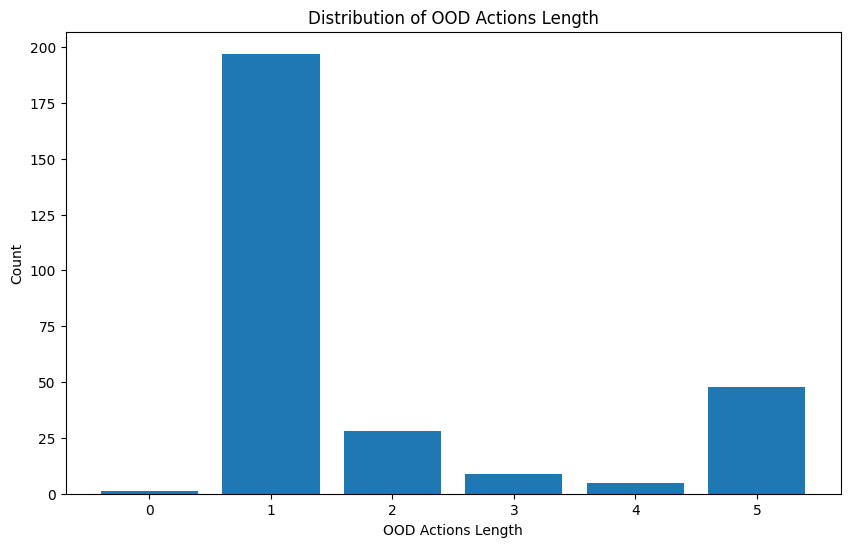

In [154]:
distribution_ood_actions(df_final_effective)

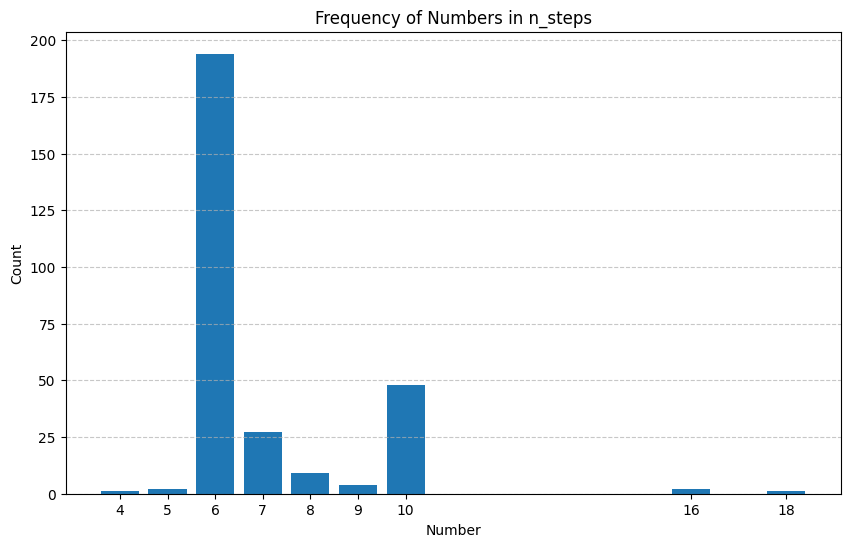

In [144]:
findStepsDistribution(df_final_effective)
# findStepsDistribution(df_early_stop)

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# Add new columns for ood_success and overall_success
def add_success_columns(df):
    # Create 'ood_success' column

    df['ood_success'] = (df['ood_terminated'] == True) | ((df["ood_terminated_clean"] == True) & (df["returned"] == True))
    #ood_fail_at_first_step_but_final_return_id'
    df['ood_partial_success'] = (df['ood_terminated'] == False) & ((df["ood_terminated_clean"] == True) & (df["returned"] == True))
    # Create 'overall_success' column
    df['overall_success'] = (df['terminated'] == True) & (df['truncated'] == False)
    return df

# Analyze success/failure relationships
def analyze_success_failures(df):
    # Add new success columns
    

    # Calculate counts for the requested conditions
    df['ood_success_overall_fail'] = (df['ood_success'] == True) & (df['overall_success'] == False)
    df['overall_success_ood_fail'] = (df['overall_success'] == True) & (df['ood_success'] == False)
    df['ood_success_overall_success'] = (df['ood_success'] == True) & (df['overall_success'] == True)
    df['ood_fail_overall_fail'] = (df['ood_success'] == False) & (df['overall_success'] == False)

    return df

# Visualize the results
def overall_result(df):
    # Define boolean columns
    boolean_columns = [
        "terminated", "truncated", 'overall_success', 
        "ood_terminated", "ood_truncated", 'ood_partial_success', 
        'ood_success', "ood_success_overall_fail", 
        'overall_success_ood_fail', 'ood_success_overall_success', 'ood_fail_overall_fail'
    ]
    
    # Calculate counts of True values and overall row counts
    counts = df[boolean_columns].apply(lambda x: (x == True).sum())
    total = len(df)
    
    # Calculate percentages and create a summary DataFrame
    percentages = (counts / total * 100).round(2)  # Rounded to 2 decimals
    result = pd.DataFrame({
        'Count_True': counts,
        'Total': total,
        'Count/Total': counts.astype(str) + '/' + str(total),
        'Percentage': percentages.astype(str) + '%'
    })
    
    # Display the result
    # print("Overall Result Analysis:")
    # print(result)
    
    return result


def draw_ood_actions_distribution(df, title):
    plt.figure(figsize=(20, 12))
    df['ood_actions'].value_counts().plot(kind='bar')
    plt.title(title)
    plt.xlabel("OOD Actions")
    plt.ylabel("Frequency")
    # plt.xticks(rotation=45)
    action_counts = df['ood_actions'].value_counts()
    # plt.xticks(ticks=range(len(action_counts.index)), labels=action_counts.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage with your DataFrame
# df = pd.DataFrame(...)  # Your DataFrame loading logic here



In [151]:
df_now = add_success_columns(df_final_effective)
df_now = analyze_success_failures(df_now)
percentages = overall_result(df_now)

In [152]:
percentages

,Count_True,Total,Count/Total,Percentage
terminated,284,288,284/288,98.61%
truncated,3,288,3/288,1.04%
overall_success,284,288,284/288,98.61%
ood_terminated,197,288,197/288,68.4%
ood_truncated,0,288,0/288,0.0%
ood_partial_success,42,288,42/288,14.58%
ood_success,239,288,239/288,82.99%
ood_success_overall_fail,3,288,3/288,1.04%
overall_success_ood_fail,48,288,48/288,16.67%
ood_success_overall_success,236,288,236/288,81.94%


In [148]:
df_now.to_csv("df_now.csv", index=False)

In [149]:
df_except_partial = df_now[df_now['ood_partial_success'] == False]
df_except_fail = df_now[df_now['ood_success'] == True]
df_only_fail = df_now[df_now['ood_success'] == False]
df_only_at_first_step = df_now[df_now['ood_terminated'] == True]
df_only_partial = df_now[df_now['ood_partial_success'] == True]

/var/folders/7k/1k7mbvr12977jg0v0v4zb0680000gn/T/ipykernel_80049/4035176102.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


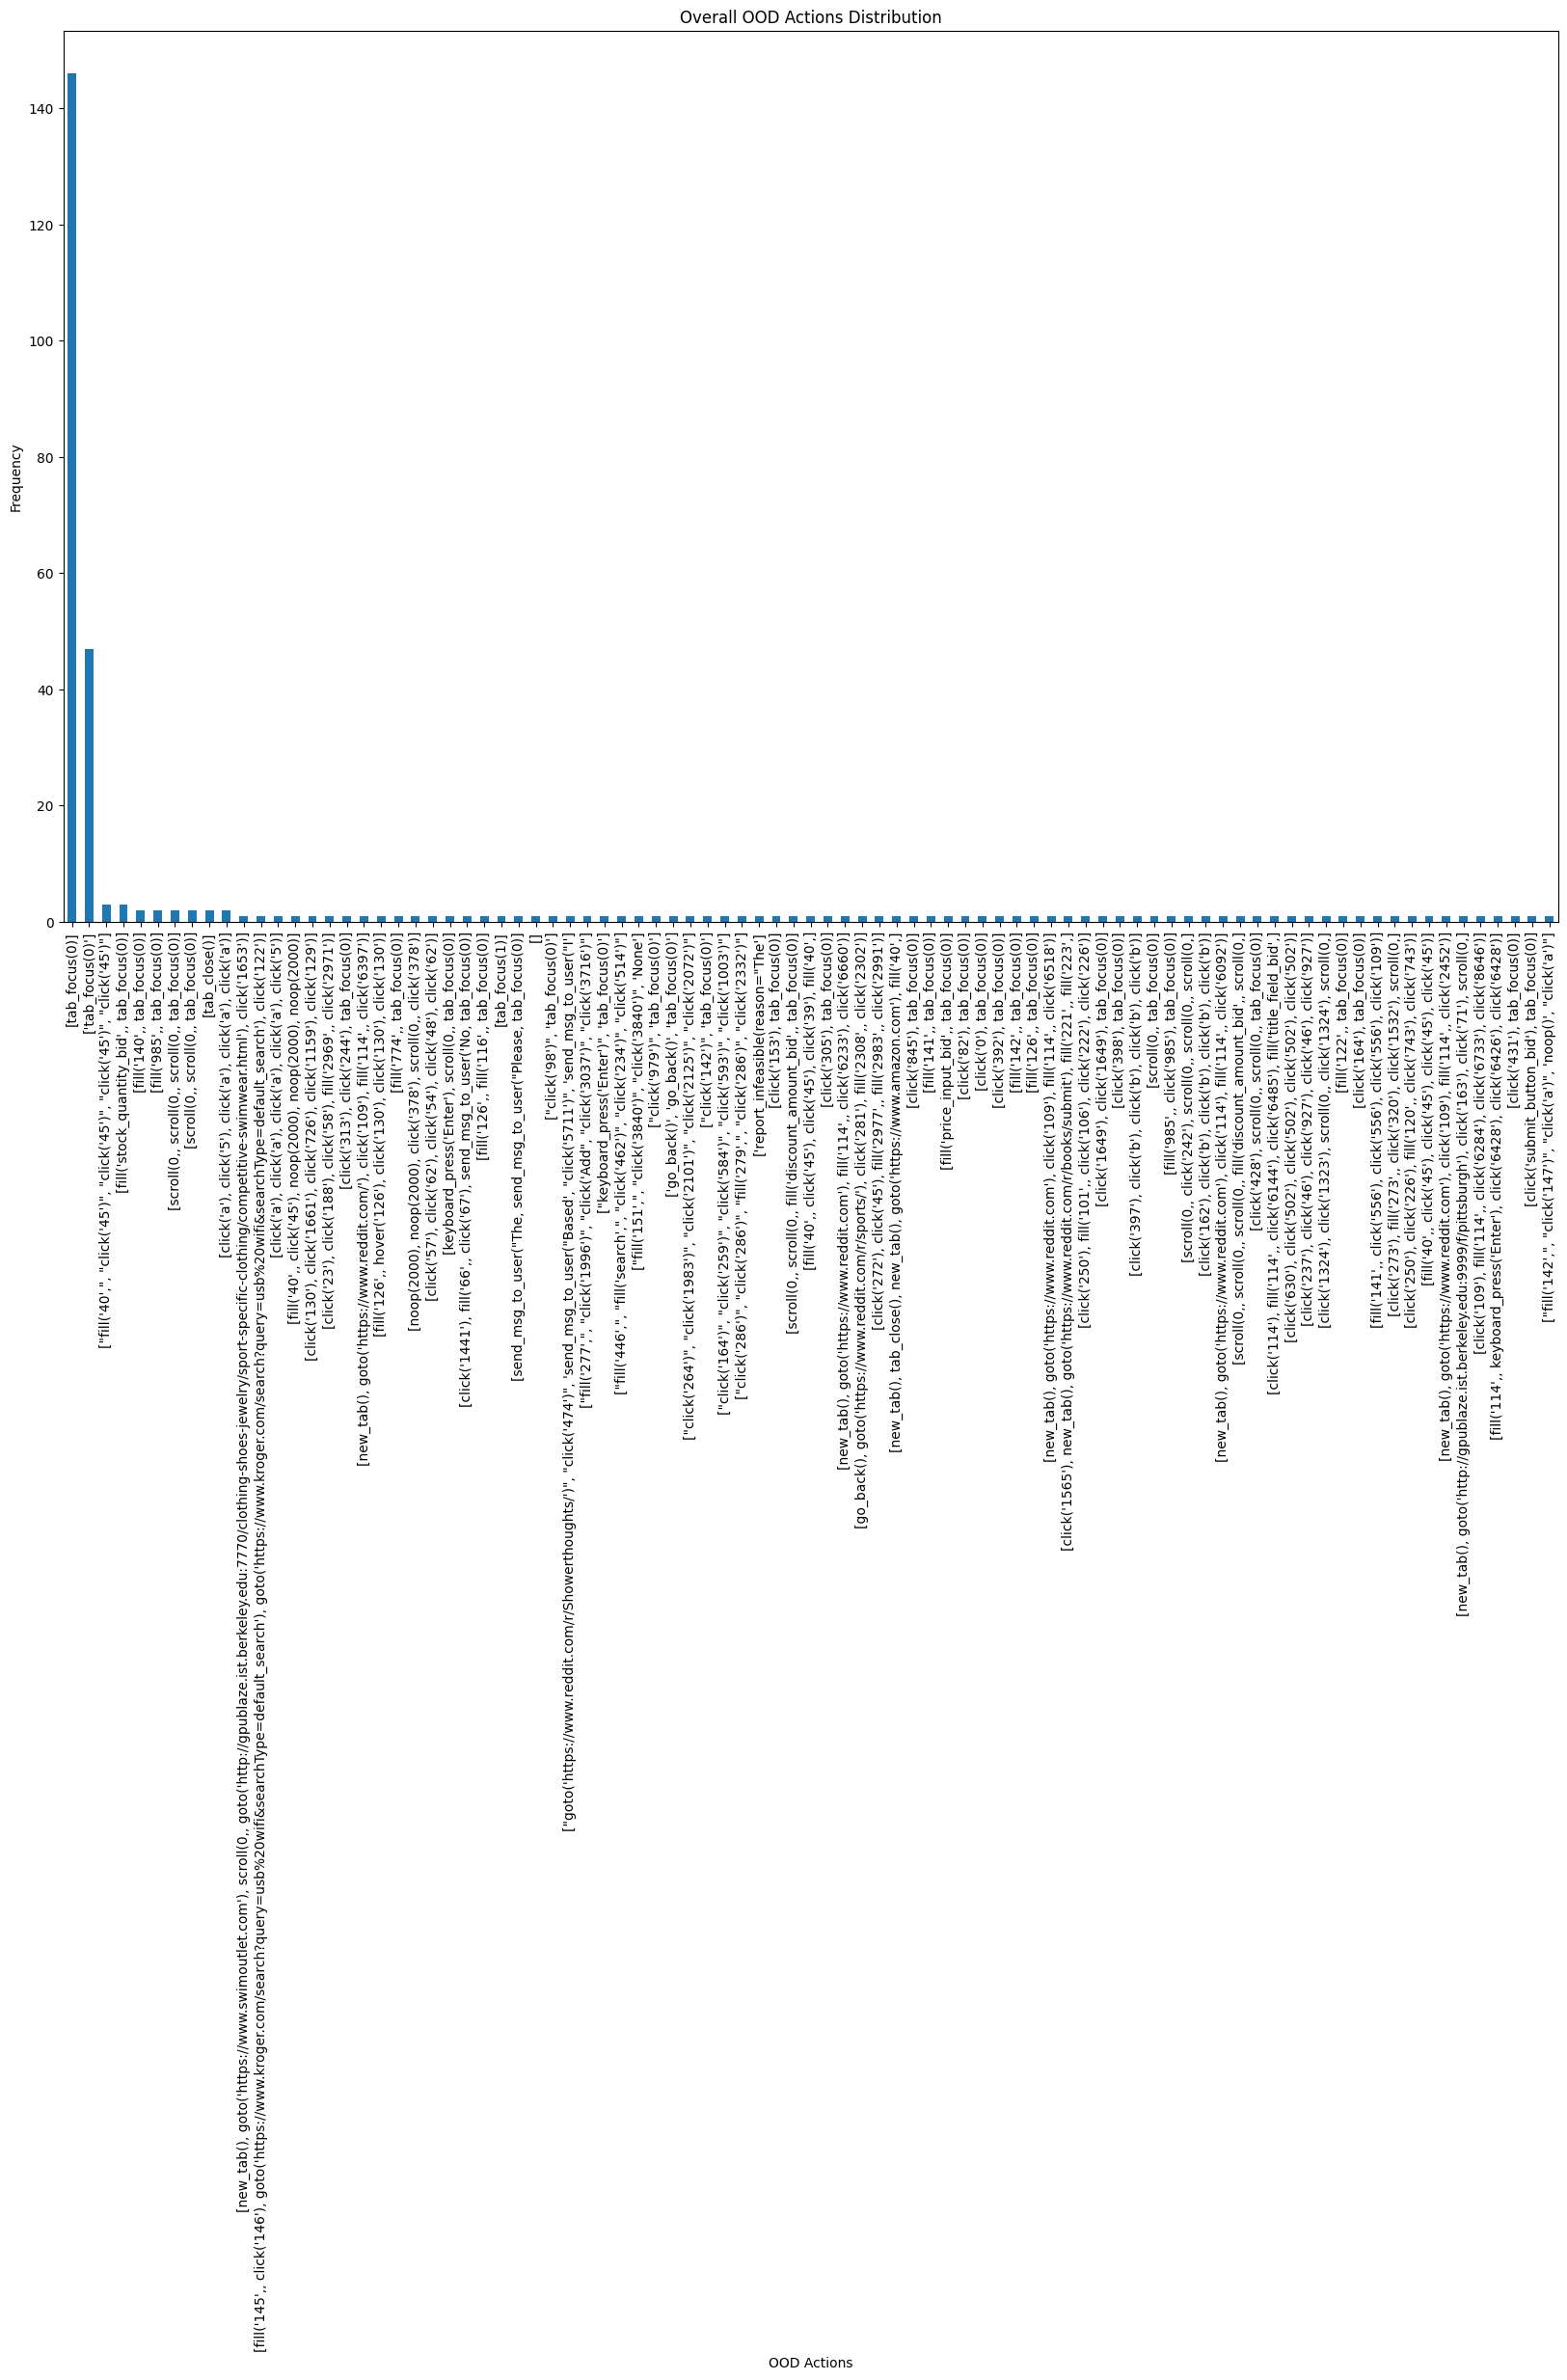

/var/folders/7k/1k7mbvr12977jg0v0v4zb0680000gn/T/ipykernel_80049/4035176102.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


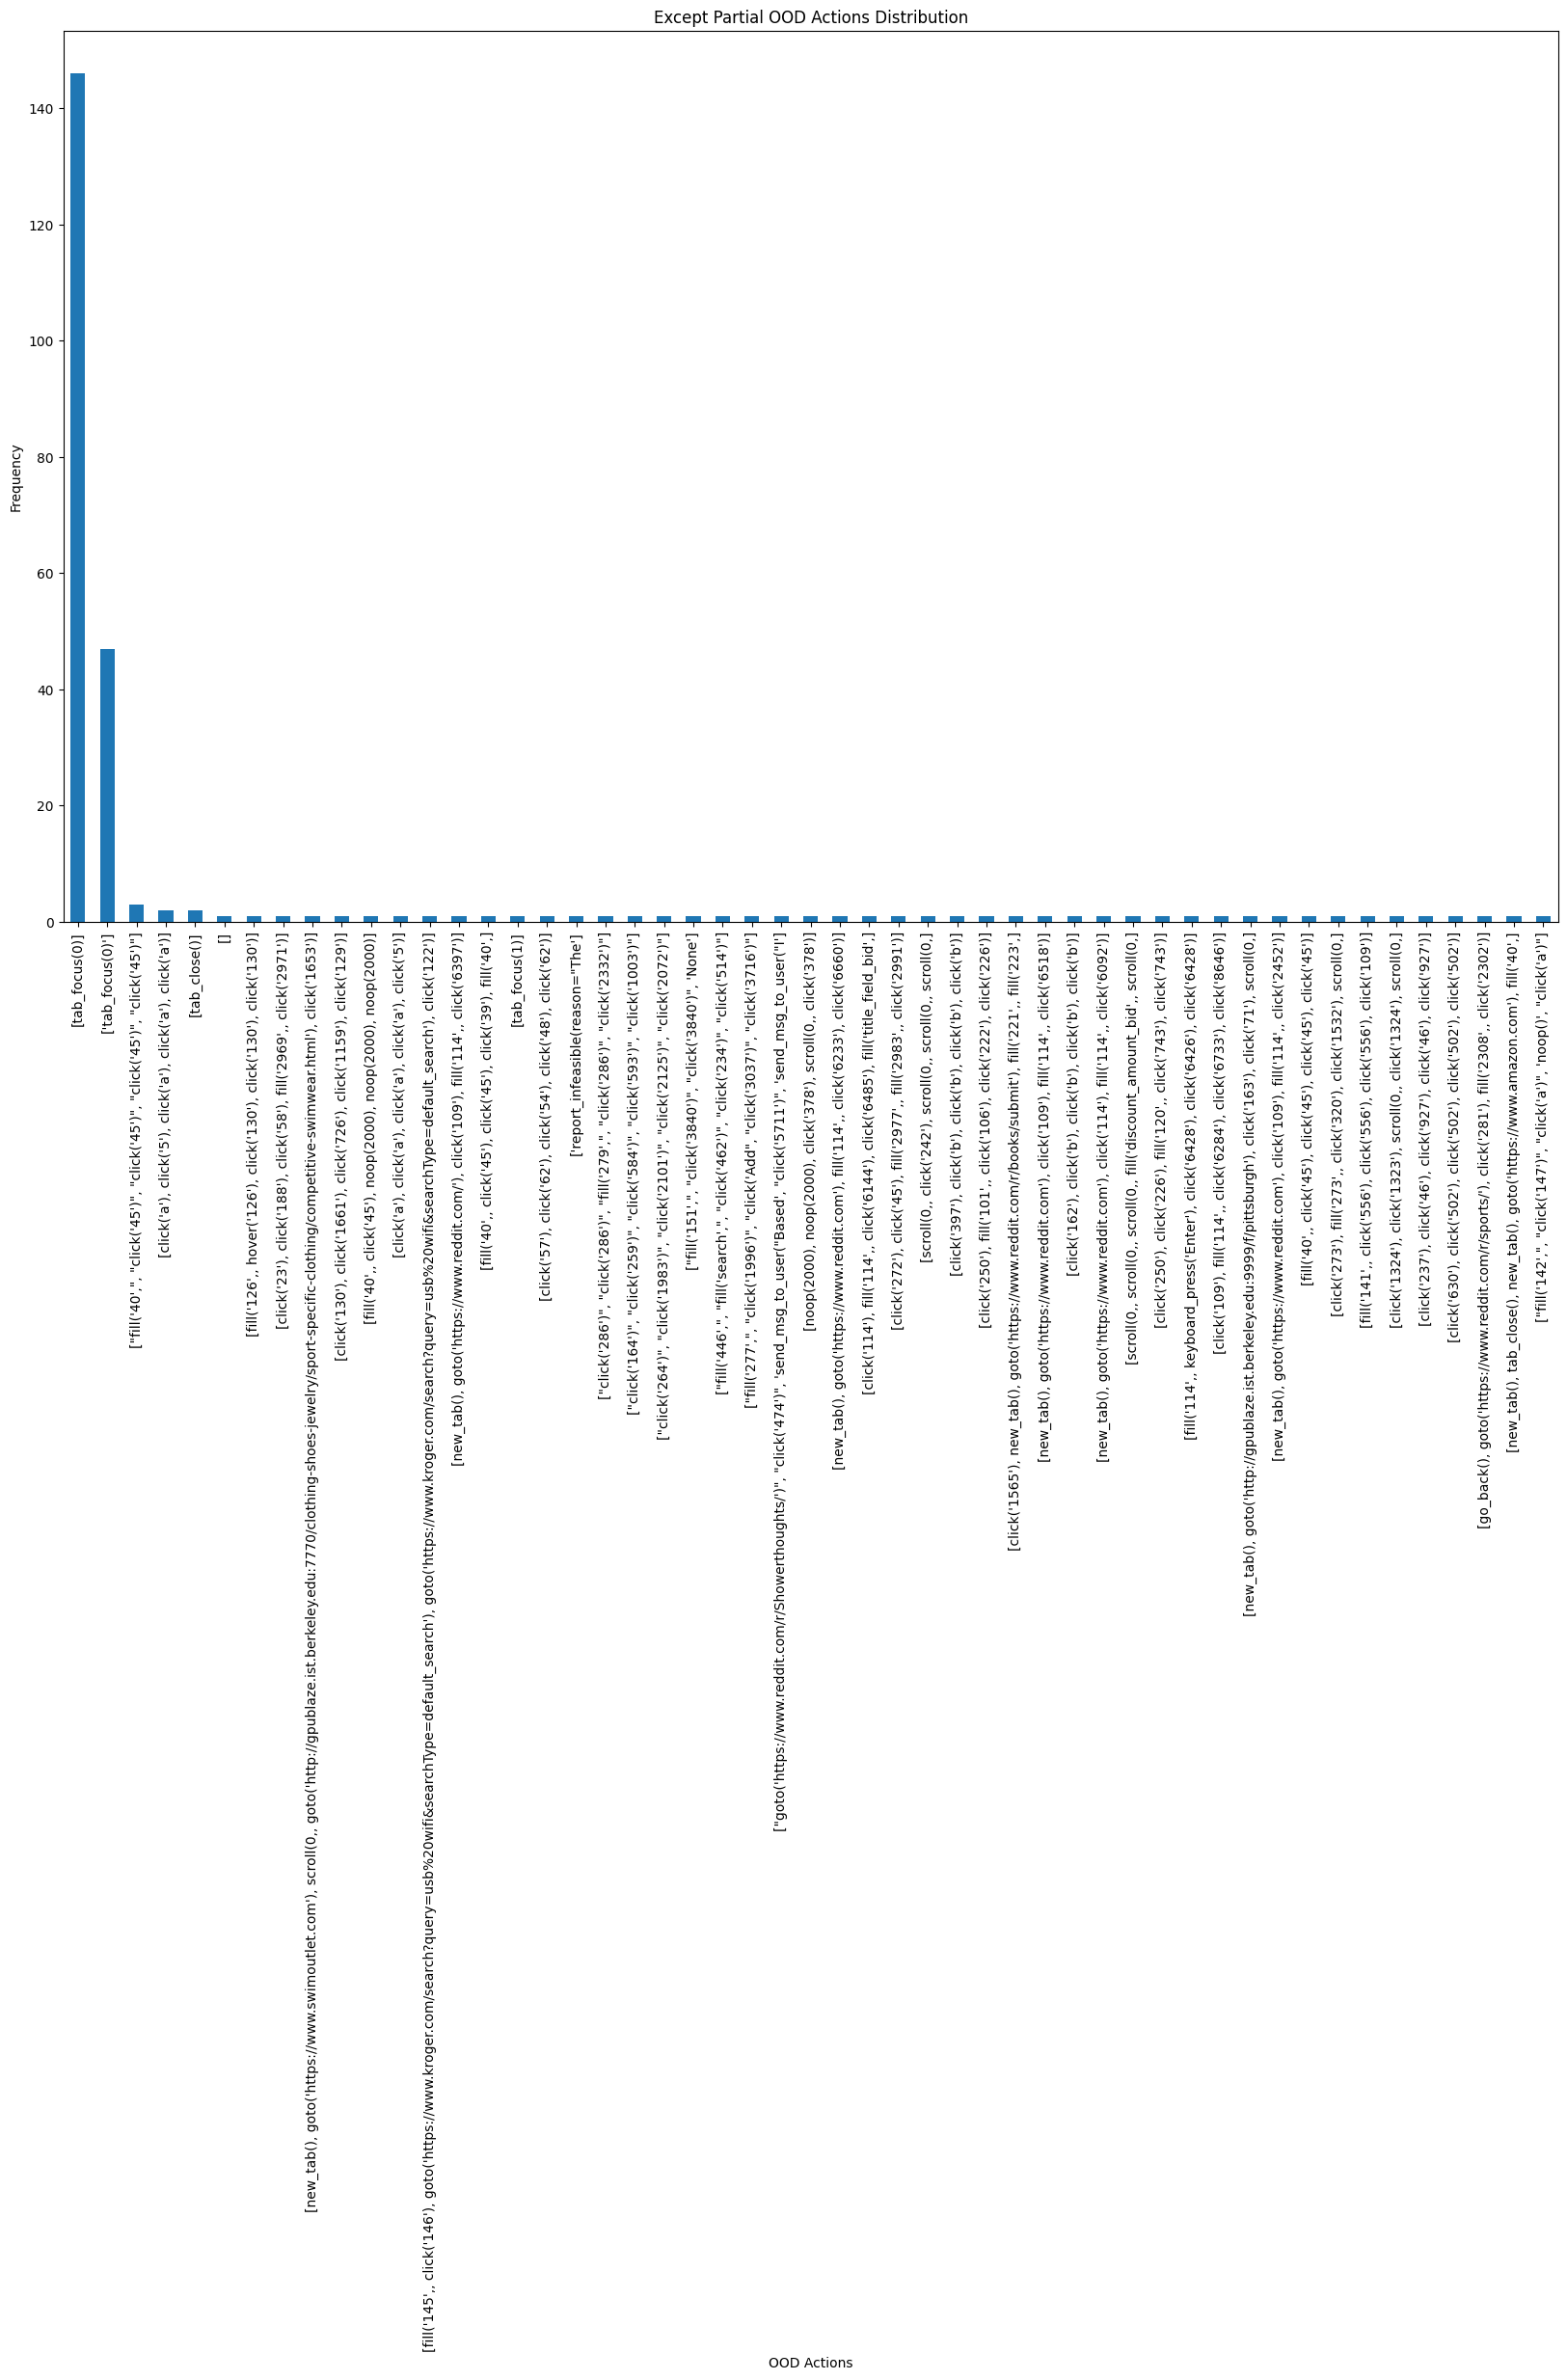

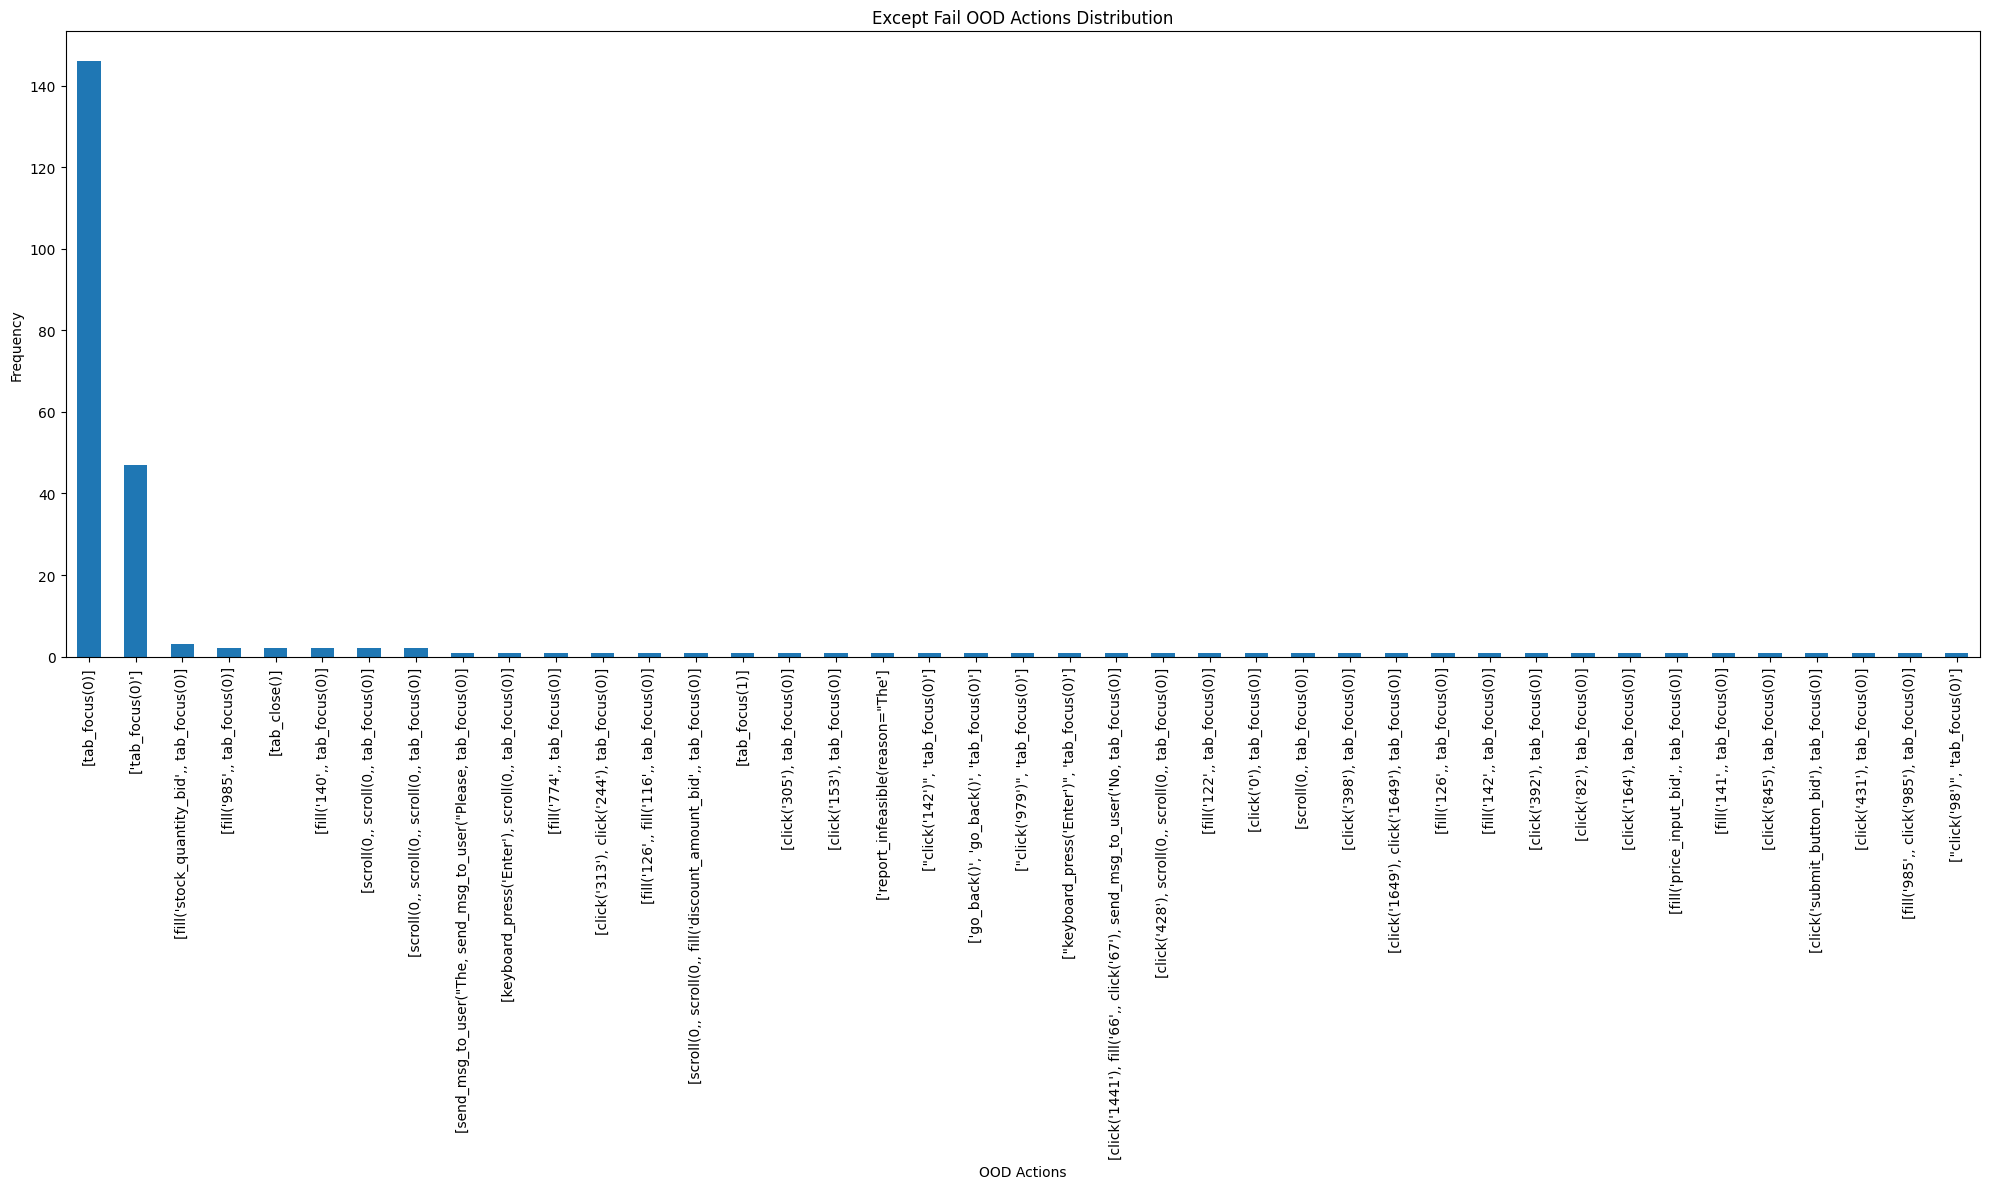

/var/folders/7k/1k7mbvr12977jg0v0v4zb0680000gn/T/ipykernel_80049/4035176102.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


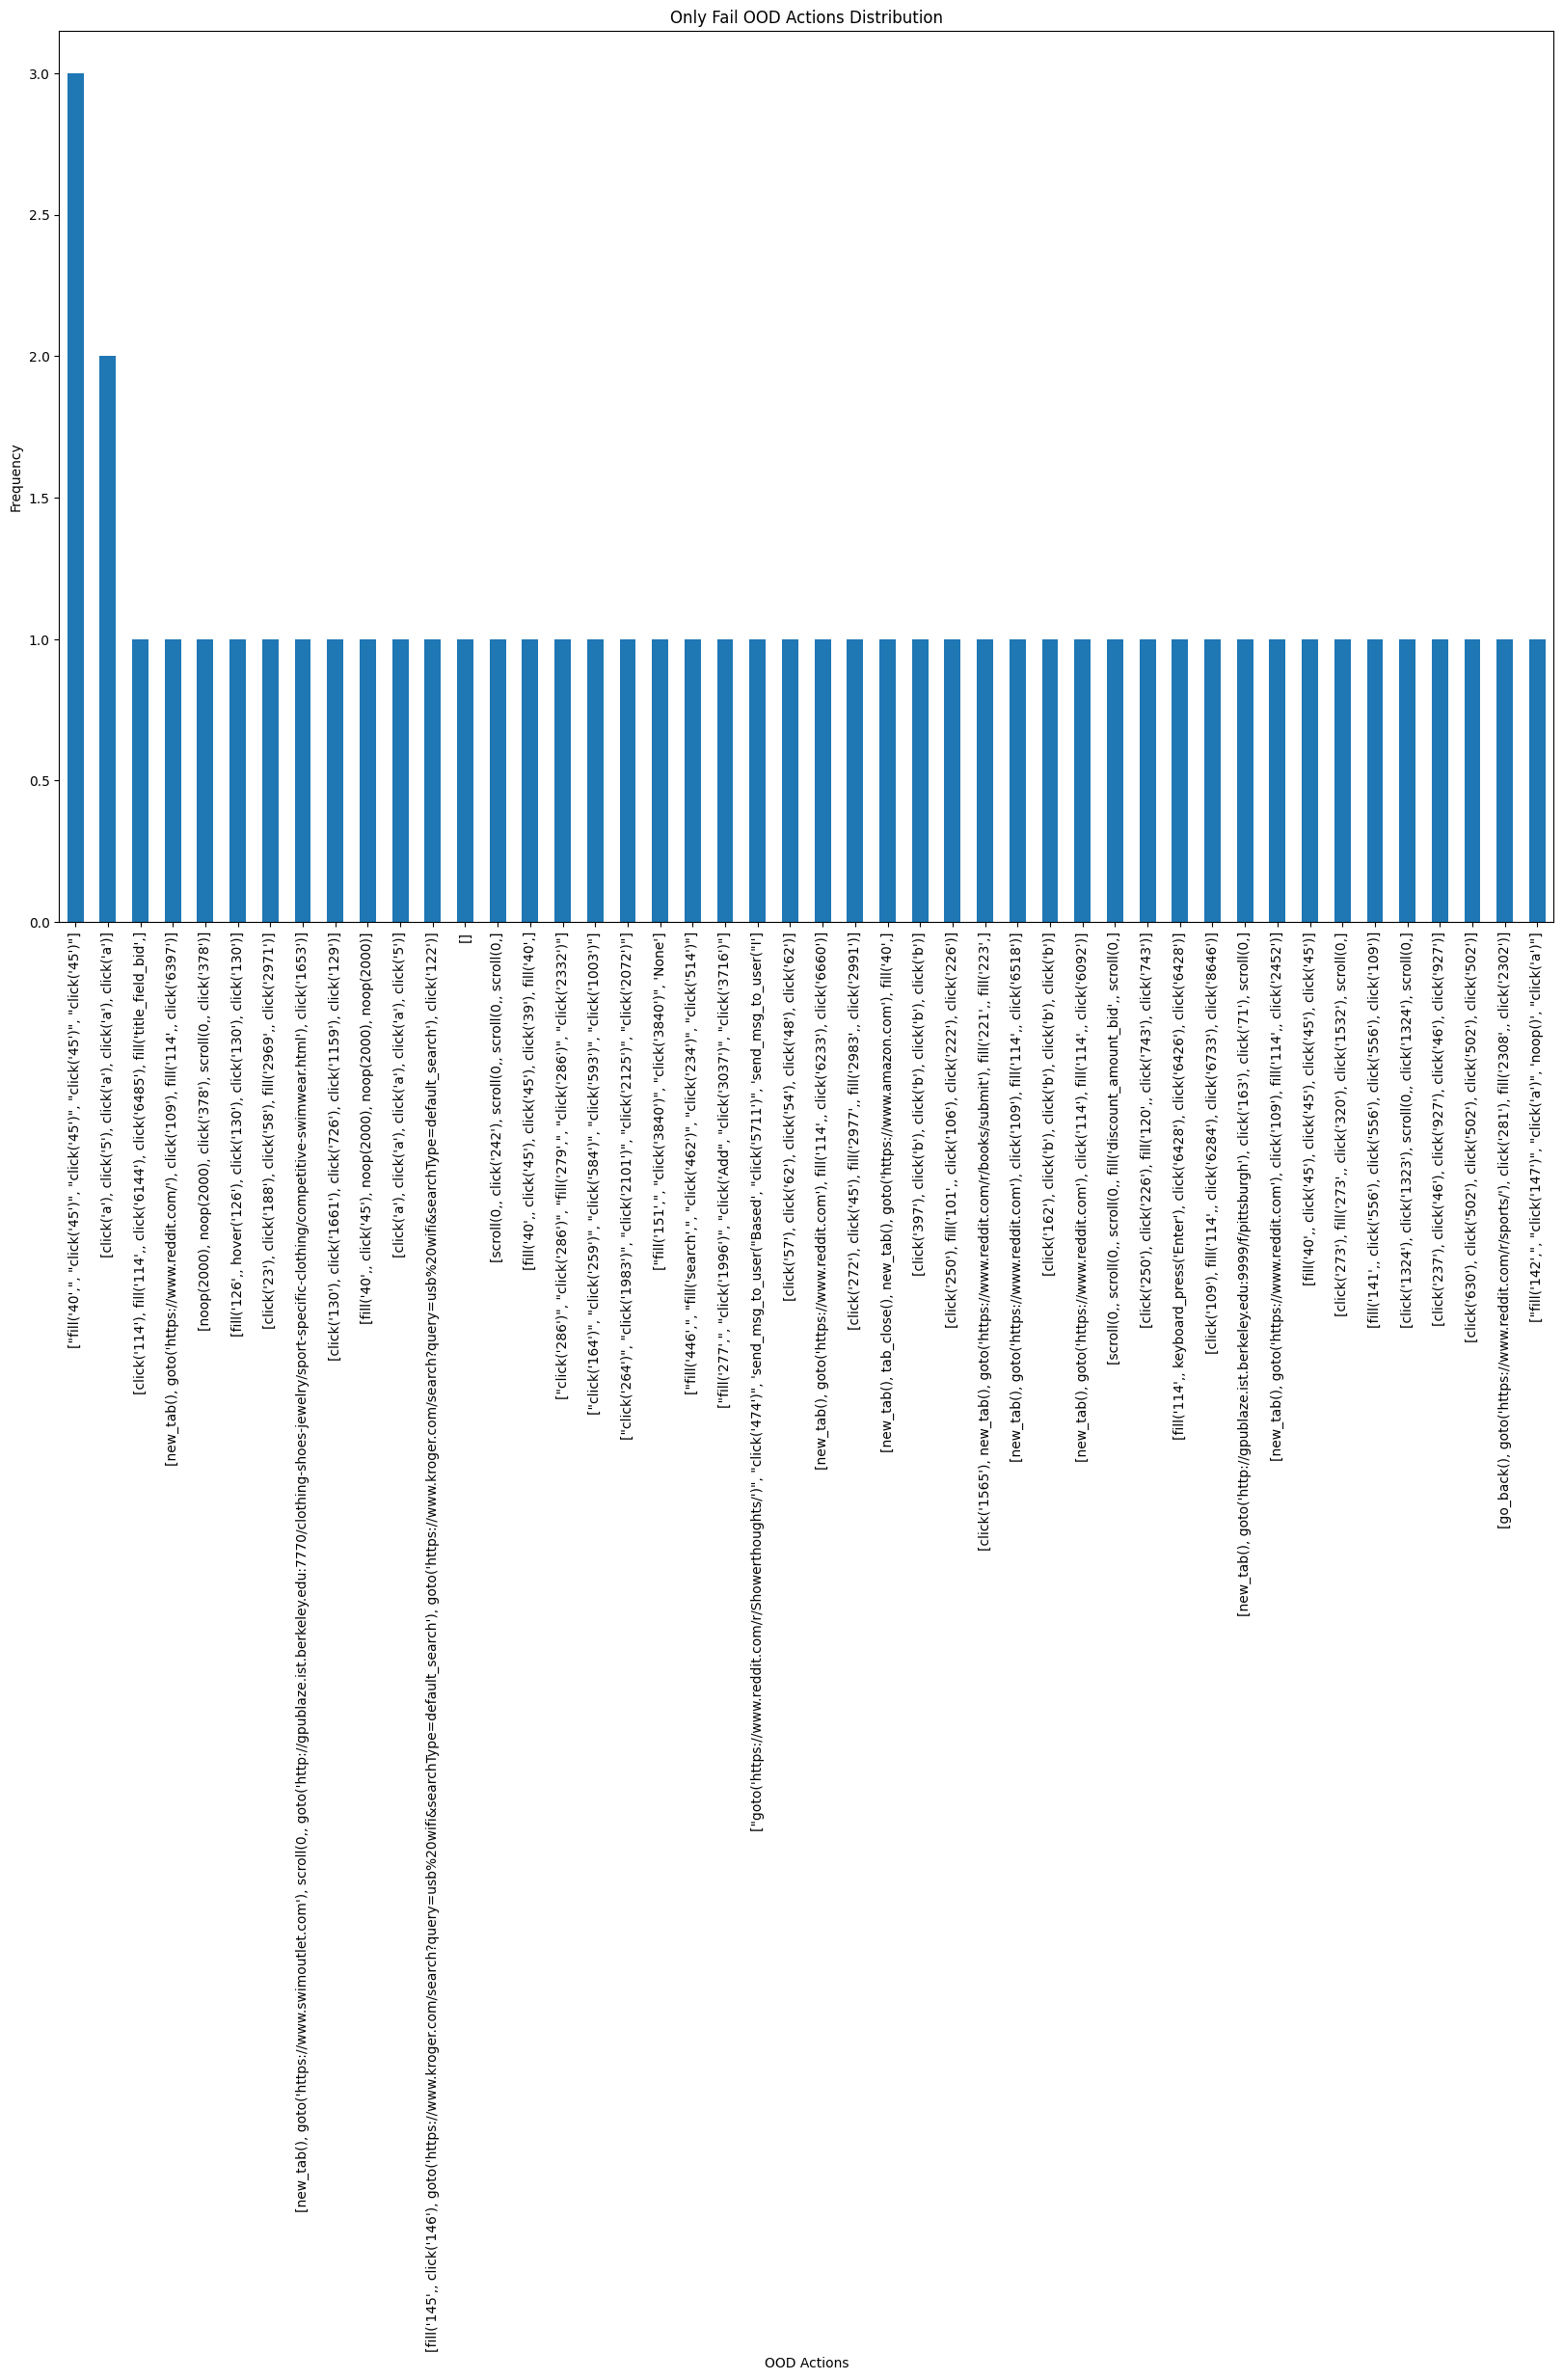

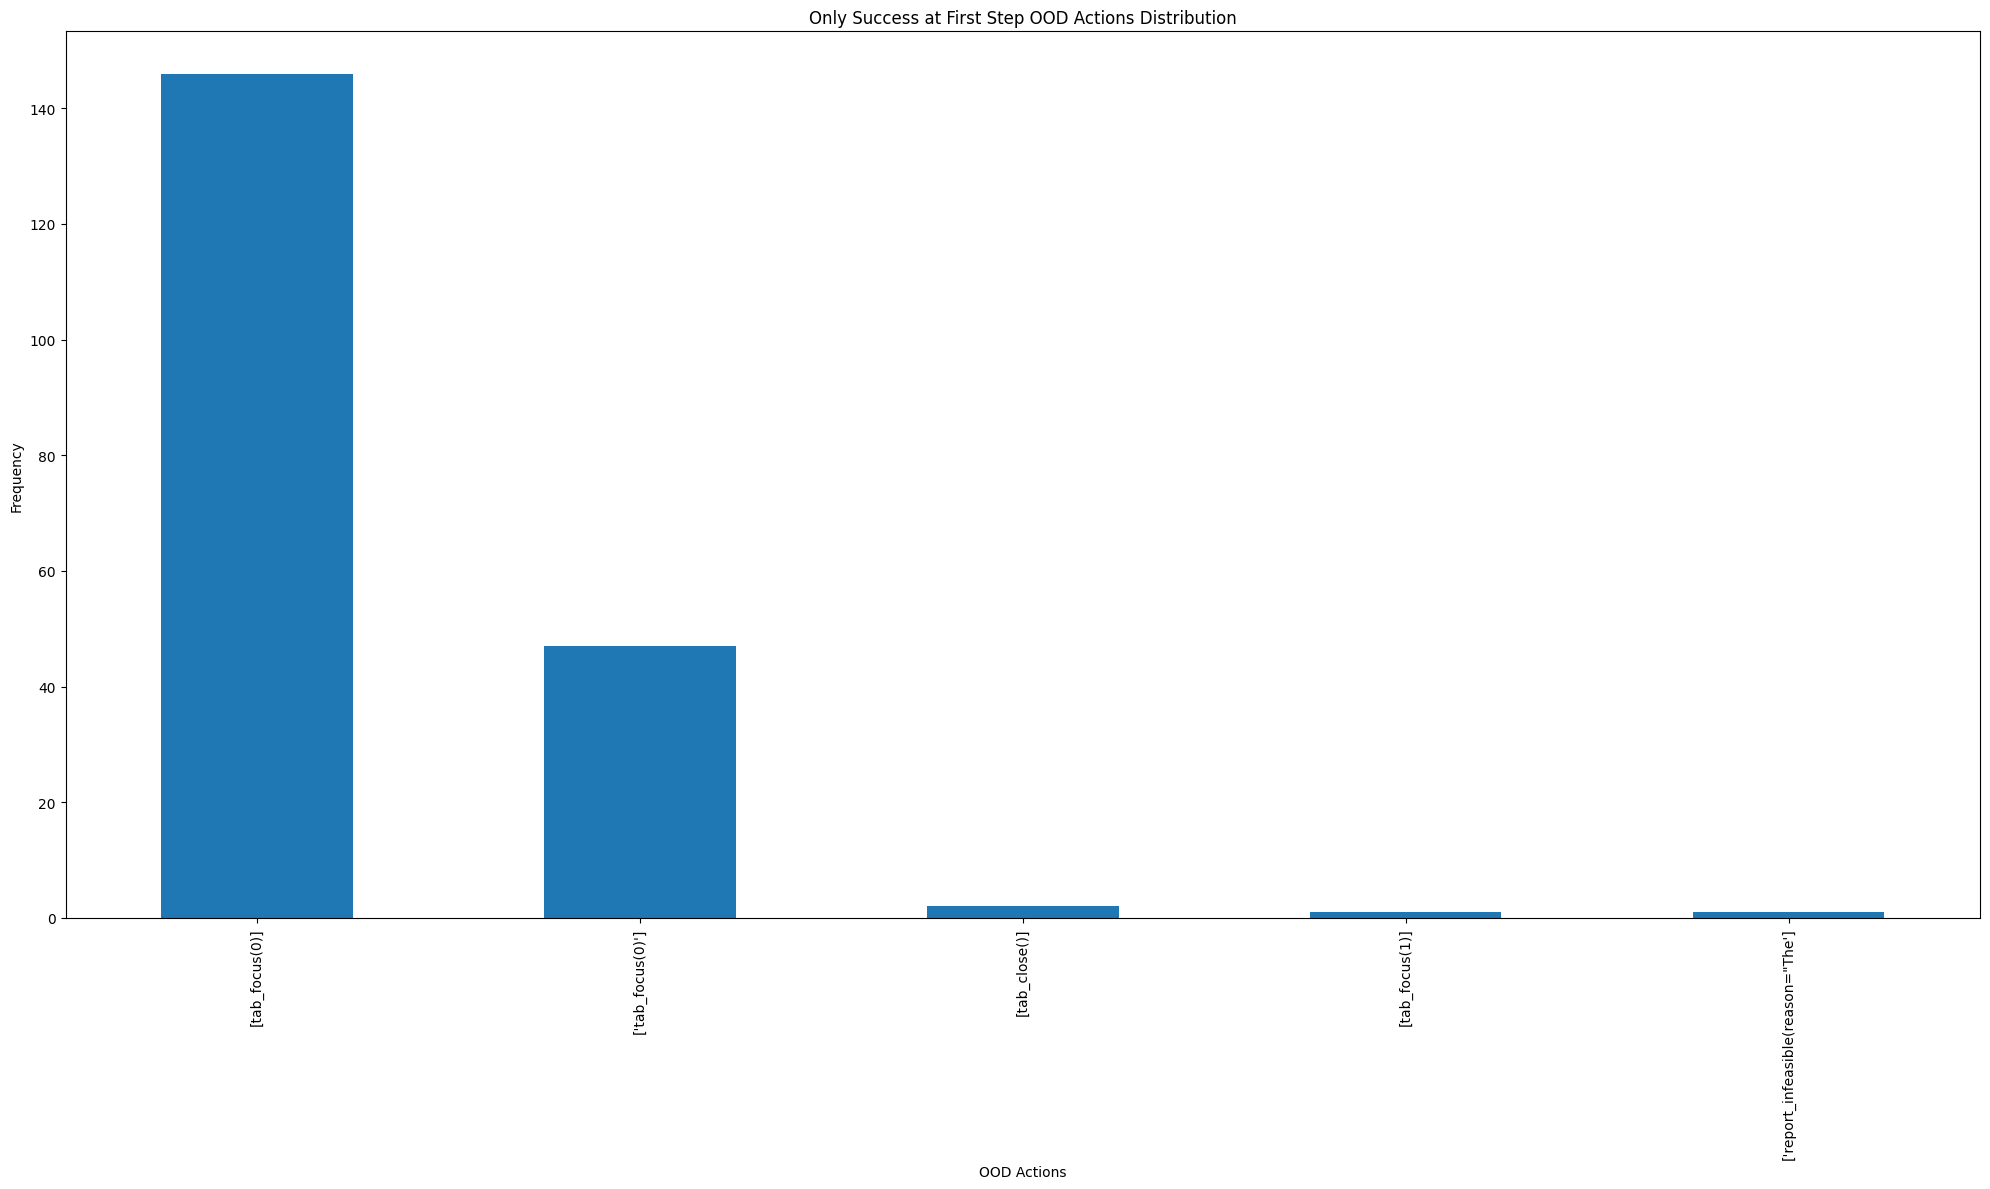

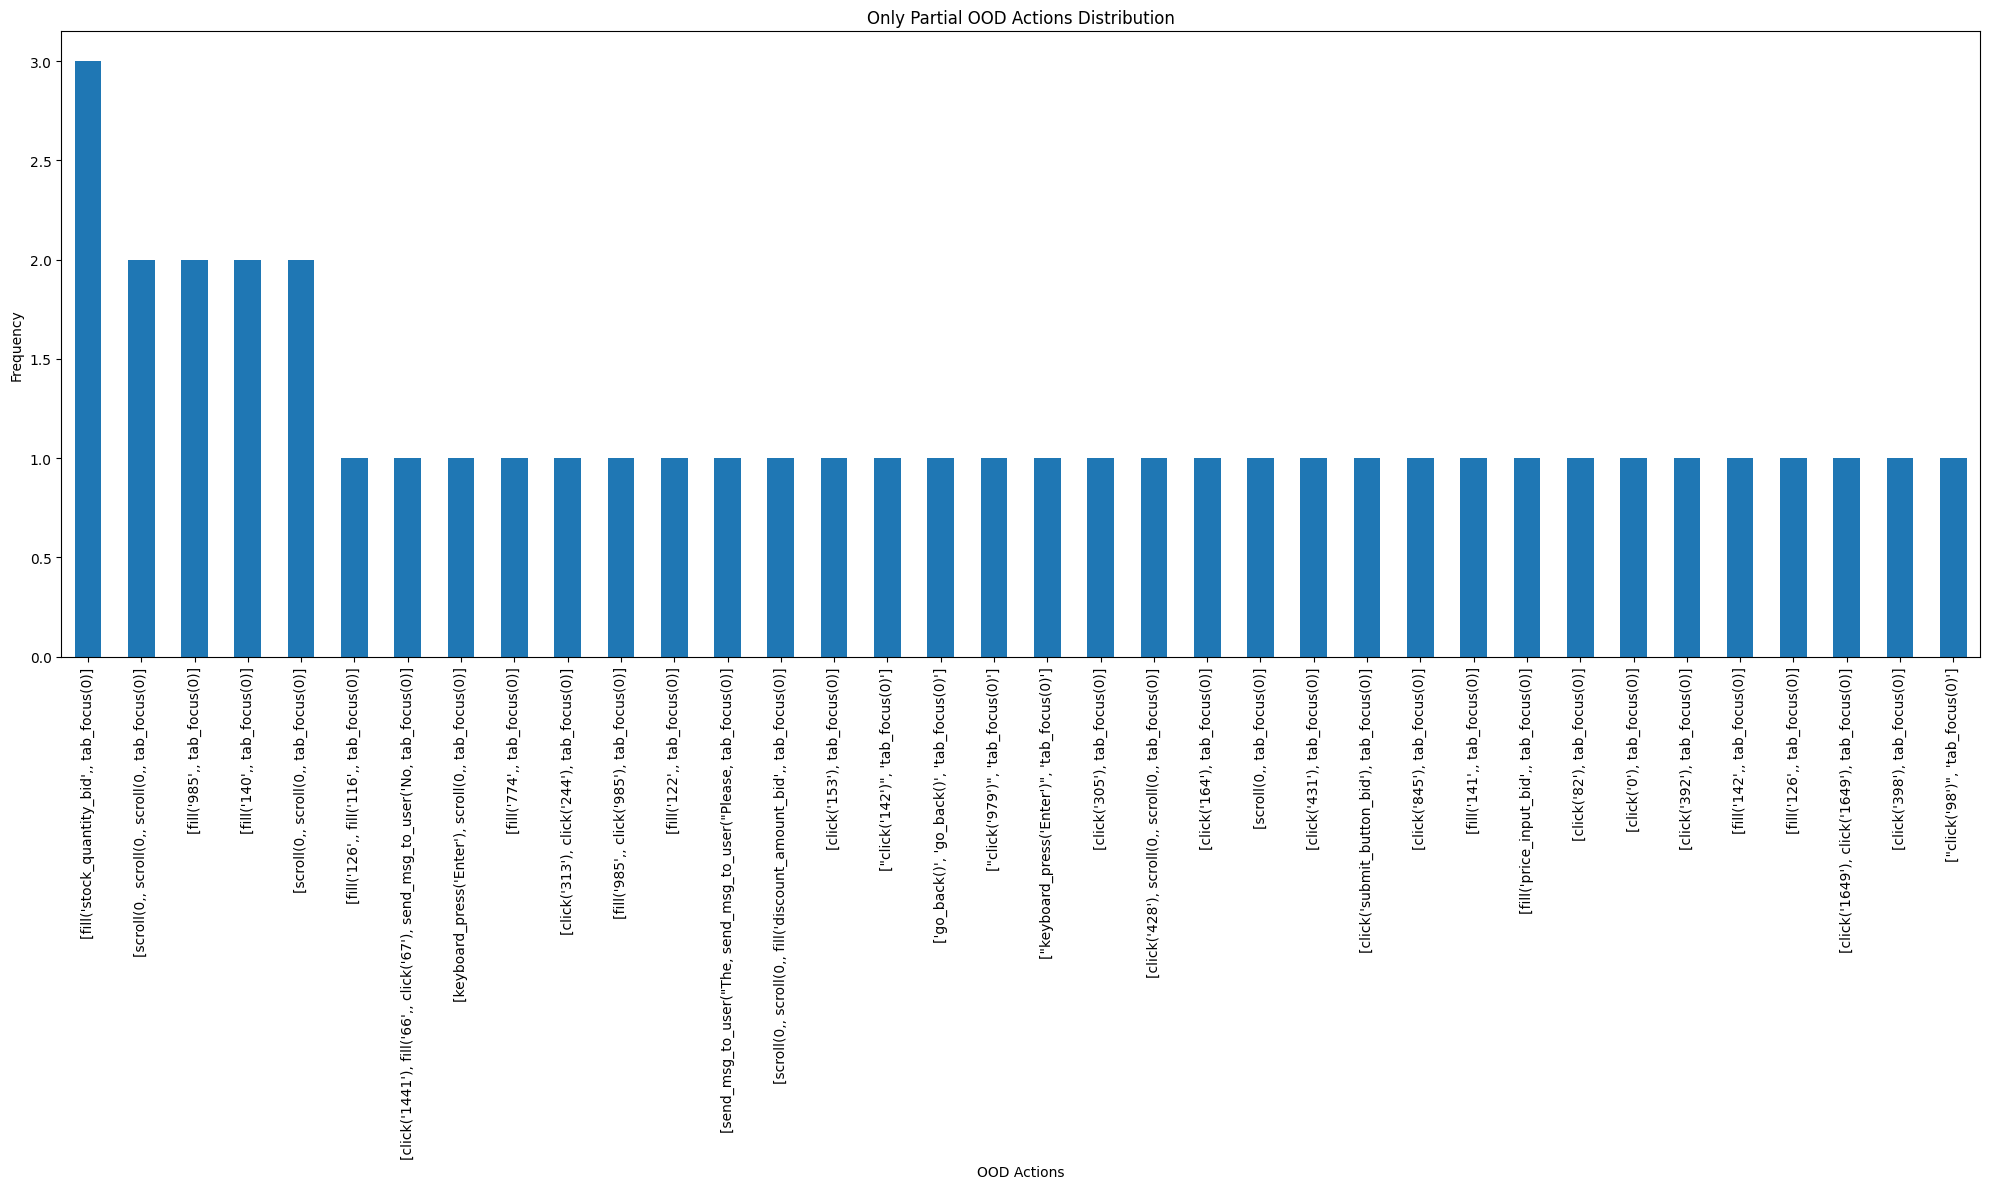

In [150]:
draw_ood_actions_distribution(df_now, "Overall OOD Actions Distribution")
draw_ood_actions_distribution(df_except_partial, "Except Partial OOD Actions Distribution")
draw_ood_actions_distribution(df_except_fail, "Except Fail OOD Actions Distribution")
draw_ood_actions_distribution(df_only_fail, "Only Fail OOD Actions Distribution")
draw_ood_actions_distribution(df_only_at_first_step, "Only Success at First Step OOD Actions Distribution")
draw_ood_actions_distribution(df_only_partial, "Only Partial OOD Actions Distribution")

dealing with next Experiment Dataset

In [155]:
output_df_overall = pd.read_csv("/Users/wangqian/Desktop/LLMAgentOODGym/agent_ood_lab/src/agentlab/agents/testing_agent/output_df.csv")

In [160]:
task_names_in_df = df_final_effective["task_name"].unique()

# Step 2: Filter 'output_df' to include only rows where task_name is NOT in task_names_in_df
df_run = output_df_overall[output_df_overall["task_name"].isin(task_names_in_df)].copy()

In [164]:
df_run.to_csv("df_run.csv", index=False)

In [161]:
df_run

,agent_name,ood_insert_step,task_name,requires_reset,sites,eval_types,task_id,browsergym_split,depends_on,ood_task_type,ood_task_id,start_url,goal
13,openai/gpt-4o,4,webarena.118,False,shopping,program_html,118,train,webarena.117,similar_platform,12,https://www.kroger.com/,Back
15,openai/gpt-4o,4,webarena.125,False,shopping,string_match,125,train,webarena.124,similar_platform,14,https://www.etsy.com/,Back
17,openai/gpt-4o,4,webarena.141,False,shopping,string_match,141,train,webarena.126,advertisement,16,https://www.rakuten.com/,Back
18,openai/gpt-4o,4,webarena.142,False,shopping,string_match,142,train,webarena.141,advertisement,17,https://www.joinhoney.com/,Back
19,openai/gpt-4o,4,webarena.143,False,shopping,string_match,143,test,webarena.142,advertisement,18,https://nordvpn.com/,Back
...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,openai/gpt-4o,4,webarena.731,False,reddit,program_html,731,test,webarena.730,similar_platform,1,https://join-lemmy.org/instances,Back
471,openai/gpt-4o,4,webarena.732,False,reddit,program_html,732,train,webarena.731,similar_platform,2,https://tildes.net/,Back
472,openai/gpt-4o,4,webarena.733,False,reddit,program_html,733,train,webarena.732,similar_platform,3,https://news.ycombinator.com/,Back
473,openai/gpt-4o,4,webarena.734,False,reddit,program_html,734,train,webarena.733,similar_platform,4,https://slashdot.org/,Back
